In [14]:
!pip install efficientnet

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import efficientnet.keras as enet

# Data Augmentation

In [16]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255) 

In [17]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 4098 images belonging to 4 classes.


In [18]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 1023 images belonging to 4 classes.


100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


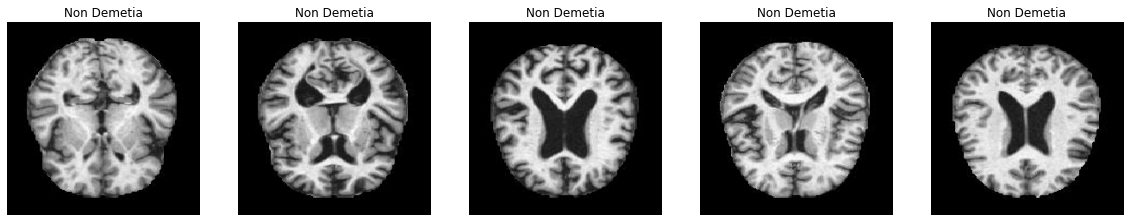

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(64)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

In [20]:
base_model = enet.EfficientNetB0(input_shape=(224,224,3), 
                                 include_top=False,
                                 weights="imagenet")

In [21]:
for layer in base_model.layers:
    layer.trainable=False

In [22]:
model=Sequential()
model.add(base_model)
model.add(AveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
average_pooling2d_1 (Average (None, 3, 3, 1280)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 3, 3, 1280)        5120      
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 3, 1280)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11520)             0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 11520)             46080     
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

In [24]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.RMSprop(lr=0.001)
METRIC = tensorflow.keras.metrics.AUC(name = 'auc')

model.compile(loss='categorical_crossentropy',
              metrics=METRIC,
              optimizer=OPT)

In [25]:
filepath = './model_tuning224_128_RMSprop1e3.h5'

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [checkpoint]

In [26]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 100,
                         
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/100
65/65 [==============================] - ETA: 0s - loss: 1.2947 - auc: 0.7304
Epoch 00001: val_auc improved from -inf to 0.65039, saving model to .\model_tuning224_128_RMSprop1e3.h5
65/65 [==============================] - 264s 4s/step - loss: 1.2947 - auc: 0.7304 - val_loss: 1.3353 - val_auc: 0.6504
Epoch 2/100
65/65 [==============================] - ETA: 0s - loss: 0.9537 - auc: 0.8440
Epoch 00002: val_auc improved from 0.65039 to 0.65739, saving model to .\model_tuning224_128_RMSprop1e3.h5
65/65 [==============================] - 258s 4s/step - loss: 0.9537 - auc: 0.8440 - val_loss: 1.2698 - val_auc: 0.6574
Epoch 3/100
65/65 [==============================] - ETA: 0s - loss: 0.8331 - auc: 0.8776
Epoch 00003: val_auc improved from 0.65739 to 0.72495, saving model to .\model_tuning224_128_RMSprop1e3.h5
65/65 [==============================] - 259s 4s/step - loss: 0.8331 - auc: 0.8776 - val_loss: 1.1563 - val_auc: 0.7249
Epoch 4/100
65/65 [==============================] -

65/65 [==============================] - ETA: 0s - loss: 0.3550 - auc: 0.9766
Epoch 00029: val_auc improved from 0.90428 to 0.90511, saving model to .\model_tuning224_128_RMSprop1e3.h5
65/65 [==============================] - 157s 2s/step - loss: 0.3550 - auc: 0.9766 - val_loss: 0.7564 - val_auc: 0.9051
Epoch 30/100
65/65 [==============================] - ETA: 0s - loss: 0.3434 - auc: 0.9777
Epoch 00030: val_auc did not improve from 0.90511
65/65 [==============================] - 158s 2s/step - loss: 0.3434 - auc: 0.9777 - val_loss: 0.8247 - val_auc: 0.8898
Epoch 31/100
65/65 [==============================] - ETA: 0s - loss: 0.3443 - auc: 0.9781
Epoch 00031: val_auc improved from 0.90511 to 0.91189, saving model to .\model_tuning224_128_RMSprop1e3.h5
65/65 [==============================] - 159s 2s/step - loss: 0.3443 - auc: 0.9781 - val_loss: 0.7238 - val_auc: 0.9119
Epoch 32/100
65/65 [==============================] - ETA: 0s - loss: 0.3197 - auc: 0.9812
Epoch 00032: val_auc impr

Epoch 59/100
65/65 [==============================] - ETA: 0s - loss: 0.2327 - auc: 0.9891
Epoch 00059: val_auc did not improve from 0.95375
65/65 [==============================] - 159s 2s/step - loss: 0.2327 - auc: 0.9891 - val_loss: 0.5256 - val_auc: 0.9530
Epoch 60/100
65/65 [==============================] - ETA: 0s - loss: 0.2299 - auc: 0.9888
Epoch 00060: val_auc did not improve from 0.95375
65/65 [==============================] - 159s 2s/step - loss: 0.2299 - auc: 0.9888 - val_loss: 0.5405 - val_auc: 0.9510
Epoch 61/100
65/65 [==============================] - ETA: 0s - loss: 0.2207 - auc: 0.9896
Epoch 00061: val_auc did not improve from 0.95375
65/65 [==============================] - 158s 2s/step - loss: 0.2207 - auc: 0.9896 - val_loss: 0.5334 - val_auc: 0.9515
Epoch 62/100
65/65 [==============================] - ETA: 0s - loss: 0.2259 - auc: 0.9895
Epoch 00062: val_auc did not improve from 0.95375
65/65 [==============================] - 160s 2s/step - loss: 0.2259 - auc: 

Epoch 90/100
65/65 [==============================] - ETA: 0s - loss: 0.1757 - auc: 0.9936
Epoch 00090: val_auc did not improve from 0.95908
65/65 [==============================] - 157s 2s/step - loss: 0.1757 - auc: 0.9936 - val_loss: 0.5354 - val_auc: 0.9527
Epoch 91/100
65/65 [==============================] - ETA: 0s - loss: 0.1654 - auc: 0.9941
Epoch 00091: val_auc did not improve from 0.95908
65/65 [==============================] - 175s 3s/step - loss: 0.1654 - auc: 0.9941 - val_loss: 0.5256 - val_auc: 0.9542
Epoch 92/100
65/65 [==============================] - ETA: 0s - loss: 0.1727 - auc: 0.9934
Epoch 00092: val_auc improved from 0.95908 to 0.95916, saving model to .\model_tuning224_128_RMSprop1e3.h5
65/65 [==============================] - 190s 3s/step - loss: 0.1727 - auc: 0.9934 - val_loss: 0.4905 - val_auc: 0.9592
Epoch 93/100
65/65 [==============================] - ETA: 0s - loss: 0.1764 - auc: 0.9932
Epoch 00093: val_auc did not improve from 0.95916
65/65 [============

In [27]:
  base_model.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

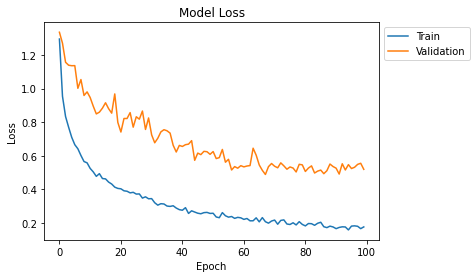

In [28]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

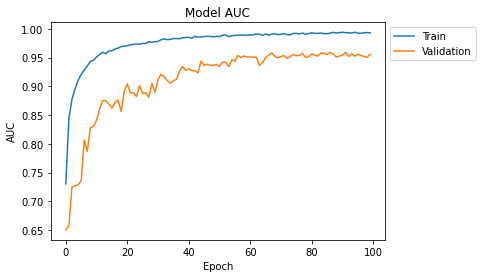

In [29]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

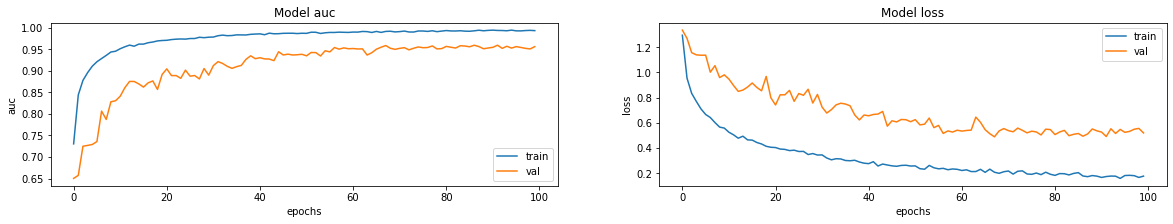

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(model_history.history[met])
    ax[i].plot(model_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [31]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 64)

Found 1279 images belonging to 4 classes.


In [32]:
model.evaluate(test_dataset)

20/20 [==============================] - 37s 2s/step - loss: 0.8401 - auc: 0.9223


[0.8400819897651672, 0.9222981333732605]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Instructions for updating:
Please use `model.predict()` instead.
99.99 % chances are there that the image is NonDemented


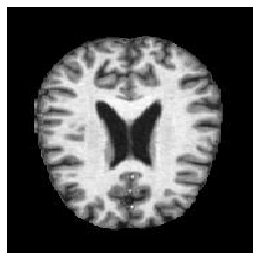

In [33]:
# Test Case 1: Non-Dementia

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/NonDemented/26 (100).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

72.44 % chances are there that the image is MildDemented


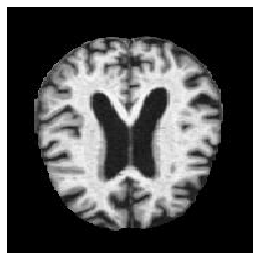

In [34]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/MildDemented/26 (19).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

100.0 % chances are there that the image is ModerateDemented


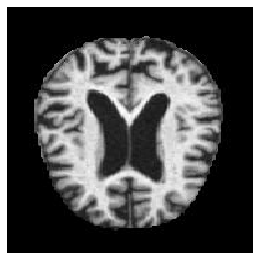

In [35]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

99.99 % chances are there that the image is VeryMildDemented


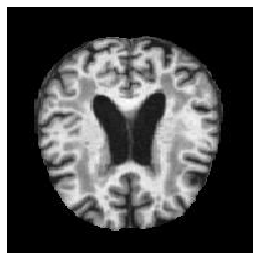

In [36]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/VeryMildDemented/26 (55).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

In [37]:
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

In [26]:
pred_ls = np.argmax(test_dataset, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

MemoryError: Unable to allocate 36.8 MiB for an array with shape (64, 224, 224, 3) and data type float32